# Transport Access - Primary Focus: Recovering PTAL
This section simply aims to show how an unweighted version of the score can be found that mirrors PTAL.

## Packages

In [1]:
!pip install numpy pandas geopandas seaborn matplotlib matplotlib_scalebar scikit-learn networkx cdlib contextily

import re
import os
import copy
from math import sqrt
from scipy.spatial import Delaunay
from scipy.stats.mstats import winsorize

# Adjusting pandas display
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Importing the installed packages
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import igraph as ig
from cdlib import NodeClustering

from matplotlib.pyplot import cm
from shapely.geometry import Point
from collections import defaultdict # to make sure dictionary copies are better mirrors of the origional
import contextily as ctx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [3]:
# path
folder_path = "YOUR_PATH_HERE/Data/2021 Census Features"

# List all files in the directory
all_files = os.listdir(folder_path)

# Get all the .csv files
csv_files = [file for file in all_files if file.endswith('.csv') or file.endswith('.CSV')]

# Print the list of CSV files
print("CSV files:")
print(csv_files)

# Create an empty list to hold dataframes
data_frames = []

# Loop over the list of csv files
for filename in csv_files:
    print(f"Loading file: {filename}")
    # Read CSV to dataframe
    df = pd.read_csv(os.path.join(folder_path, filename))
    # Append dataframe to the list
    data_frames.append(df)

# Print the number of dataframes
print(f"Loaded {len(data_frames)} dataframes.")

CSV files:
['Age2021.csv', 'Sex2021.csv', 'Disability2021.csv', 'Ethnicity2021.csv', 'Employment2021.csv', 'WorkDist2021.csv', 'HouseholdDep2021.csv', 'HouseholdType2021.csv', 'Cars2021.csv']
Loading file: Age2021.csv
Loading file: Sex2021.csv
Loading file: Disability2021.csv
Loading file: Ethnicity2021.csv
Loading file: Employment2021.csv
Loading file: WorkDist2021.csv
Loading file: HouseholdDep2021.csv
Loading file: HouseholdType2021.csv
Loading file: Cars2021.csv
Loaded 9 dataframes.


In [4]:
population = data_frames[8].groupby("Lower layer Super Output Areas Code")["Observation"].sum()
population_df = population.reset_index() # Convert the Series to a DataFrame
data_frames[8] = data_frames[8].merge(population_df, how="left", on='Lower layer Super Output Areas Code')
data_frames[8].rename(columns={"Observation_x": "Observation", "Observation_y": "Population"}, inplace=True)

## Create the Census Vector
While this is not used to calculate the PTAL equivalent, it is included here in the case of someone wanting to expand the code.

In [5]:
# Prepare the population data
population_df = data_frames[8].copy()
population_df.set_index("Lower layer Super Output Areas Code", inplace=True)

# Dictionary to store total populations of each LSOA
total_population_by_lsoa = population_df['Population'].to_dict()

# Calculate the total population of all LSOAs (entire London)
total_population_london = sum(total_population_by_lsoa.values())

# Dictionary to store total counts of each observation type across all LSOAs
total_counts = {}

# Initialise a counter for generating cc codes, a dictionary to hold the data, and a dataframe to hold cc origins
cc_counter = 1
data_dict = {}
cc_origin = pd.DataFrame(columns=['cc', 'origin_info', 'filename'])

for idx, df in enumerate(data_frames):
    print(f"Loading DataFrame: {idx}")

    # Extract column names containing 'categories)' and not 'code'
    code_columns = [col for col in df.columns if 'categories)' in col.lower() and 'code' not in col.lower()]

    # Update total counts for each observation type
    for col in code_columns:
        for code, count in df[df['Observation'] != 0].groupby(col)['Observation'].sum().items():
            total_counts[code] = total_counts.get(code, 0) + count

    # Generate 'cc' codes and store in the cc_origin dataframe
    code_to_cc = {}
    for col in code_columns:
        for code in df[col].unique():
            if code not in code_to_cc:
                cc_code = 'cc' + str(cc_counter)
                code_to_cc[code] = cc_code
                cc_counter += 1

                # Add to cc_origin dataframe
                cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)

    # Special handling for the population DataFrame
    if idx == 8:
        # Assign a 'cc' for the population column
        population_cc = 'cc' + str(cc_counter)
        cc_counter += 1

        # Add to cc_origin dataframe
        cc_origin = cc_origin.append({'cc': population_cc, 'origin_info': 'population', 'filename': idx}, ignore_index=True)

    # Calculate the actual concentrations and add to the dictionaries
    for i, row in df.iterrows():
        lsoa_code = row['Lower layer Super Output Areas Code']

        # If this code isn't in the dictionary yet, add it
        if lsoa_code not in data_dict:
            data_dict[lsoa_code] = {'census': {}}

        for col in code_columns:
            observation_type = row[col]
            cc_code = code_to_cc[observation_type]

            if row['Observation'] != 0:
                # Numerator: observation of group x in this LSOA / total population of this LSOA
                concentration_numerator = row['Observation'] / total_population_by_lsoa[lsoa_code]

                # Denominator: total number of group x for all of London / total population of London
                concentration_denominator = total_counts[observation_type] / total_population_london

                concentration = concentration_numerator / concentration_denominator
                data_dict[lsoa_code]['census'][cc_code] = concentration

        # Add the population to the dictionary using the 'cc' as the key, if it's the 9th dataframe
        if idx == 8:
            data_dict[lsoa_code]['census'][population_cc] = row['Population']

Loading DataFrame: 0


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 1


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 2


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 3


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 4


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 5


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 6


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 7


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 8


<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-2c3353c8c515>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

In [6]:
lsoas2021 = gpd.read_file('YOUR_PATH_HERE/Data/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025/LSOA_2021_EW_BGC.shp')
lsoas2021['centroids'] = lsoas2021.geometry.centroid

The CSV census data and shapefile are still for the entirety of England. They need to be subset

In [7]:
# List of London boroughs
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley", "Camden", "City of London", "Croydon", "Ealing",
    "Enfield", "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
    "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea", "Kingston upon Thames", "Lambeth",
    "Lewisham", "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Southwark", "Sutton",
    "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]

# Subset the 'lsoas2021' shapefile by borough names
lsoas_london = lsoas2021[lsoas2021['LSOA21NM'].str.contains('|'.join(london_boroughs))]

In [8]:
# Remove the last 5 characters from the LSOA21NM column
lsoas_london['LSOA21NM2'] = lsoas_london['LSOA21NM'].str[:-5]

# Get all unique values in the modified LSOA21NM column
unique_values = lsoas_london['LSOA21NM2'].unique()

# Display the unique values
print("Unique values:")
print(unique_values)

Unique values:
['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster' 'Brentwood']


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


An extra borough is included: Brentwood. This is because the regular expression to find the LSOAs captures Brentwood by accident.

In [9]:
# Remove LSOAs containing "Brentwood" in LSOA21NM
lsoas_london = lsoas_london[~lsoas_london['LSOA21NM'].str.contains("Brentwood")]

# Drop the LSOA21NM2 column
lsoas_london = lsoas_london.drop(columns=['LSOA21NM2'])

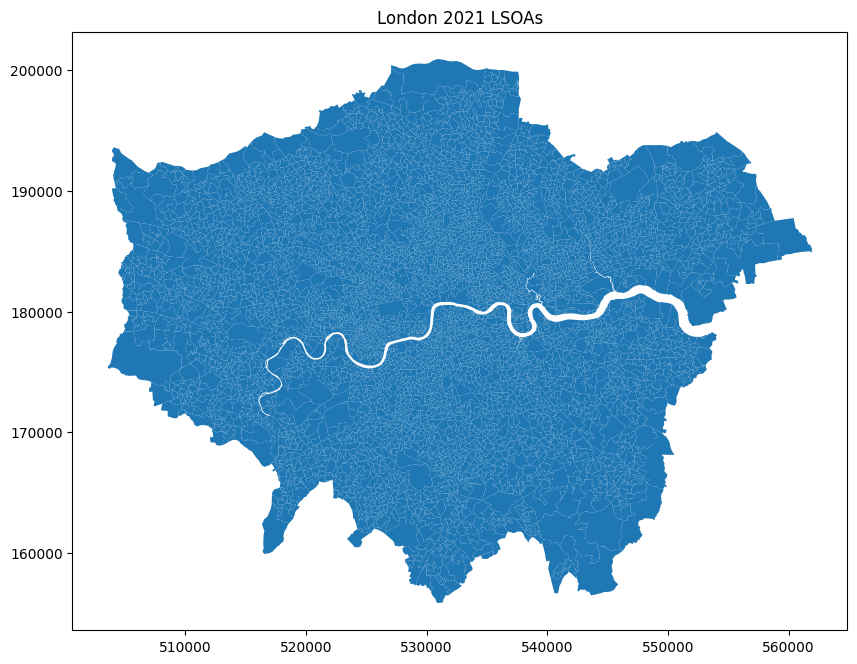

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
lsoas_london.plot(ax=ax)
ax.set_title("London 2021 LSOAs")
plt.show()

In [11]:
transport = pd.read_csv("YOUR_PATH_HERE/Data/r5r Data/r5r_access_data_transport.csv")

In [12]:
transport.sort_values("travel_time_p50",ascending=False)

,Unnamed: 0,V1,LSOA21CD,LSOA21NM,GlobalID,centroid_lat,centroid_lon,lat,lon,id,travel_time_p50,opportunity,percentile,cutoff,accessibility
2636,2637,2637,E01002775,Islington 014D,bbf4c09e-a2a0-4203-8236-66e0f2868f79,51.55,-0.09,51.55,-0.09,2637,inf,Transport,50,20,1
3670,3671,3671,E01003847,Richmond upon Thames 002B,88f8bcb6-4d90-49b3-9d7a-0b01becb87d0,51.48,-0.30,51.48,-0.30,3671,inf,Transport,50,20,0
2330,2331,2331,E01002444,Hillingdon 031A,ce3598bd-76ab-49c8-b525-7efe3e997214,51.47,-0.47,51.47,-0.47,2331,inf,Transport,50,20,0
3914,3915,3915,E01004114,Sutton 025D,844d6c86-029b-43aa-9adf-dd0a0ac363bf,51.34,-0.22,51.34,-0.22,3915,inf,Transport,50,20,0
2233,2234,2234,E01002344,Havering 029B,809580a0-085d-436a-b0d3-b27afbb0cd67,51.51,0.21,51.51,0.21,2234,inf,Transport,50,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,812,812,E01000846,Camden 014C,7ba87a06-21cd-44a5-bc84-5c0afc9cdf00,51.54,-0.16,51.54,-0.16,812,1.00,Transport,50,20,68
2658,2659,2659,E01002797,Islington 018B,739c2af0-a300-4db0-b4a5-089065dcf7eb,51.54,-0.09,51.54,-0.09,2659,1.00,Transport,50,20,85
4862,4863,32619,E01034580,Merton 005F,ee25bf59-d3ab-48d5-bf78-1eaf24bb1b53,51.42,-0.18,51.42,-0.18,32619,1.00,Transport,50,20,51
2631,2632,2632,E01002770,Islington 004B,8f69dd85-58cc-4f62-8afa-394270b01eb9,51.57,-0.14,51.57,-0.14,2632,1.00,Transport,50,20,76


In [13]:
# drop rows where the travel_time is inf - this stems from r5r's notation of areas that can't access anything
transport2 = transport[transport["travel_time_p50"] != float('inf')]

In [14]:
# Create a new instance of the data dictionary vector with the census data to use for transport
data_dict_transport = copy.deepcopy(data_dict)

Standardise the r5r outputs

In [15]:
# Create an instance of StandardScaler & Transform the df so it is all z_score based
scaler = StandardScaler()

# Transform the 'travel_time_p50' column using the scaler
transport2['zscore_tt'] = scaler.fit_transform(transport2[['travel_time_p50']])

# Transform the 'accessibility' column using the scaler
transport2['zscore_access'] = scaler.fit_transform(transport2[['accessibility']])

# Calculate density
transport2['density'] = transport2['accessibility'] / 32258 # the number of pt access points in the dataset

# Get the z_score of density
transport2['density_zscore'] = scaler.fit_transform(transport2[['density']])

<ipython-input-15-0e9ba4948607>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transport2['zscore_tt'] = scaler.fit_transform(transport2[['travel_time_p50']])
<ipython-input-15-0e9ba4948607>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transport2['zscore_access'] = scaler.fit_transform(transport2[['accessibility']])
<ipython-input-15-0e9ba4948607>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [16]:
transport2 = gpd.GeoDataFrame(transport2, geometry=gpd.points_from_xy(transport2.lon, transport2.lat), crs="EPSG:4326")
transport2 = transport2.to_crs(crs="EPSG:27700")
transport_new = copy.deepcopy(transport2)

## Make Access Vector

The code works with the transport data for different LSOAs. First, it looks at each row in the transport_new dataframe. For every row, it checks if its area code, or LSOA code, is already in the data_dict_transport dictionary created above – which already contains the census information. If it's not, the code adds the normalised transport access data like 'density_zscore' and 'zscore_tt' to the dictionary. If the code is already there, it just updates the information.

Next, the code creates vectors, which are a way of grouping the transport and census data together for each area. It does this by matching the LSOA codes in the dictionary to those in the transport_new dataframe. If it finds a match, it combines the data into one vector and saves it in the final_vectors dictionary. If there's no match, it moves on to the next one. The end result is a collection of vectors in the final_vectors dictionary, ready for further analysis.

In [17]:
# Iterate over the rows in transport_new
for i, row in transport_new.iterrows():
    # Get the 'LSOA21CD' value
    lsoa_code = row['LSOA21CD']

    # If this code isn't in the dictionary yet, add the key-value pairs for zscore_access, density_zscore, and zscore_tt
    if lsoa_code not in data_dict_transport:
        data_dict_transport[lsoa_code] = {
            'density_zscore': {'value': row['density_zscore']},
            'zscore_tt': {'value': row['zscore_tt']}
        }
    else:  # If the code is already in the dictionary, just update the values
        for key in ['density_zscore', 'zscore_tt']:
            # Check if key is a dictionary, if not initialise as a dictionary
            if type(data_dict_transport[lsoa_code].get(key)) is not dict:
                data_dict_transport[lsoa_code][key] = {}

            data_dict_transport[lsoa_code][key]['value'] = row[key]

In [18]:
# Initialise a new dictionary to hold the final vectors
final_vectors = {}

for lsoa_code, lsoa_data in data_dict_transport.items():
    # Filter the transport_new dataframe to get the row corresponding to this LSOA code
    transport_data = transport_new[transport_new['LSOA21CD'] == lsoa_code]

    # If the dataframe is empty (i.e., this LSOA code isn't in transport_new), continue
    if transport_data.empty:
        continue

    # Otherwise, extract the density_zscore and zscore_tt values
    density = transport_data['density_zscore'].values[0]
    tt = transport_data['zscore_tt'].values[0]

    # Combine the census data
    vector = np.array([density, tt])

    # Store the vector in the new dictionary
    final_vectors[lsoa_code] = vector

In [19]:
final_vectors_transport = copy.deepcopy(final_vectors)

## Calculate the Scores

The code below calculates the scores

In [20]:
# New dictionary for storing the final results
final_transit_scores = {}

for lsoa_code, lsoa_data in data_dict_transport.items():

    # Initialise variables for scaled values
    scaled_density_zscore = 0
    scaled_zscore_tt = 0

    # Find the max z-score for inverting the travel time
    # We need to do so otherwise it would be like a longer travel time would have a higher value
    max_z = max([lsoa_data['zscore_tt']['value'] for lsoa_code, lsoa_data in data_dict_transport.items() if 'zscore_tt' in lsoa_data])

    # Check if the categories exist in the dictionary and assign the corresponding values
    if 'density_zscore' in lsoa_data:
        density = lsoa_data['density_zscore']['value']
    if 'zscore_tt' in lsoa_data:
        tt = (max_z-lsoa_data['zscore_tt']['value'])

    # Add the values together to get the final score
    final_score = density + tt

    # Normalise by area if the LSOA code is in lsoas_london
    if lsoa_code in lsoas_london.index:
        area = lsoas_london.loc[lsoa_code, 'area']
        if area > 0:  # Avoid division by zero
            final_score = final_score / area

    # Add it to the final score dictionary
    final_transit_scores[lsoa_code] = final_score

final_transport_pop_scores = final_transit_scores

Scale using the min-max scalar to normalise across London and make the score more interpretable

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))

# Extract dictionary values to lists
final_transport_scores_list = list(final_transit_scores.values())

# Convert the lists to numpy arrays, reshape them into 2D arrays and scale them
rescaled_final_transport_scores = scaler.fit_transform(np.array(final_transport_scores_list).reshape(-1, 1)).flatten()

# Create new dictionaries with the LSOA codes and the corresponding scaled scores
final_transit_scores_scaled = dict(zip(final_transit_scores.keys(), rescaled_final_transport_scores))

Mapping

In [22]:
# Create a DataFrame from the final_transport_pop_scores dictionary
scores_df = pd.DataFrame.from_dict(final_transit_scores_scaled, orient='index', columns=['score'])
scores_df.reset_index(inplace=True)
scores_df.rename(columns={'index': 'LSOA21CD'}, inplace=True)

In [23]:
# Apply winsorisation to the 'score' column so the trends are more evident
scores_df['winsorised_score'] = winsorize(scores_df['score'], limits=[0.002, 0.002])

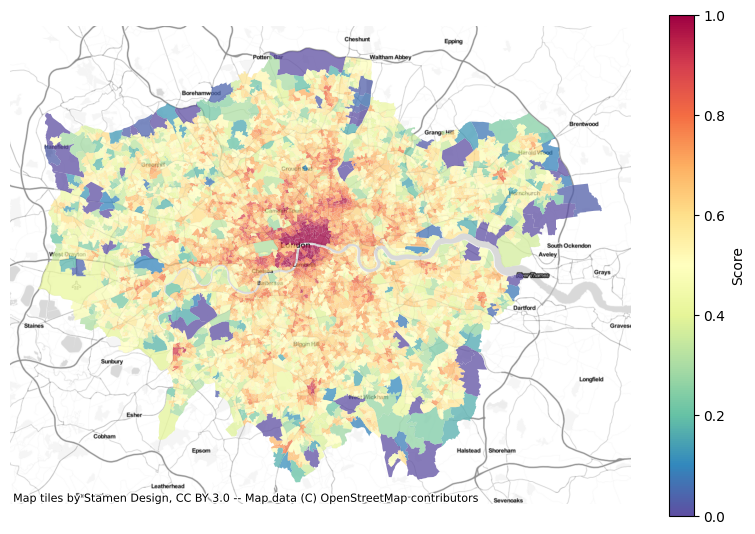

In [24]:
merged_data = lsoas_london.merge(scores_df, on='LSOA21CD')
# EPSG:3857 is the code for Web Mercator
merged_data = merged_data.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10,10))
merged_data.plot(column='winsorised_score', cmap='Spectral_r', linewidth=0.01, edgecolor='0.8', legend=False, ax=ax, alpha=0.75)

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax, orientation='vertical', shrink=0.65)
cbar.set_label("Score")

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.axis('off')
plt.show()

<Axes: >

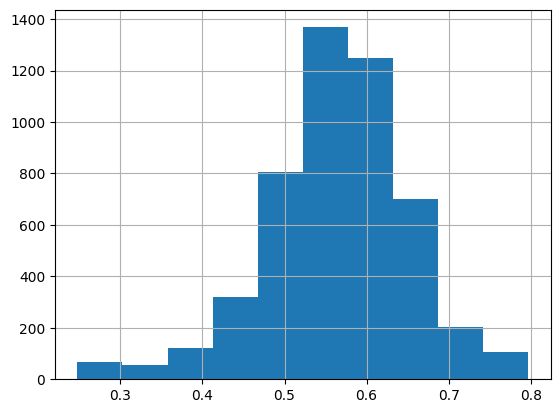

In [25]:
merged_data.winsorised_score.hist()